In [143]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from keras.layers import *
from keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer


import warnings
warnings.filterwarnings('ignore')


In [144]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder


In [145]:
DATA_PATH = 'C:\\Users\\LAP TECHNOLOGY\\Desktop\\project\\archive\\merged_rides_weather(100000).csv'   # غيّر المسار لو لازِم


In [146]:
df=pd.read_csv(DATA_PATH)

In [147]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,name,hour,date,temp,clouds,pressure,rain,humidity,wind
0,1.93,Lyft,2018-12-01 11:17:55.791,Back Bay,Haymarket Square,22.5,1.0,Lux Black,11,2018-12-01,32.580000,0.400000,1022.140000,0.019036,0.79,4.340000
1,1.05,Lyft,2018-11-29 06:53:05.635,North End,North Station,11.0,1.0,Lyft XL,6,2018-11-29,37.738571,0.774286,1000.315714,0.017956,0.70,10.212857
2,1.64,Uber,2018-12-16 22:30:08.069,Back Bay,Northeastern University,8.5,1.0,UberX,22,2018-12-16,41.860000,0.900000,1012.430000,0.101100,0.78,11.040000
3,2.53,Lyft,2018-12-02 06:08:03.130,Northeastern University,Beacon Hill,22.5,1.0,Lux Black,6,2018-12-02,38.380000,1.000000,1020.700000,0.017956,0.83,2.750000
4,1.71,Lyft,2018-12-16 00:40:15.848,South Station,West End,5.0,1.0,Shared,0,2018-12-16,42.690000,0.170000,1023.050000,0.129213,0.71,6.390000


In [148]:

# ------------------ 2) ء ------------------
if 'time_stamp' in df.columns:
    df['dt'] = pd.to_datetime(df['time_stamp'], errors='coerce')
else:
    # build from date + hour (+ minute if exists)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['hour'] = df['hour'].fillna(0).astype(int)
    if 'minute' in df.columns:
        df['minute'] = df['minute'].fillna(0).astype(int)
    else:
        df['minute'] = 0
    df['dt'] = df.apply(lambda r: pd.Timestamp(r['date'].date()) + pd.Timedelta(hours=int(r['hour'])) + pd.Timedelta(minutes=int(r['minute'])), axis=1)

# drop invalid dt rows
df = df[~df['dt'].isna()].copy()
df = df.sort_values('dt').reset_index(drop=True)
print("After dt/sort rows:", len(df))
print("Start:", df['dt'].min(), "End:", df['dt'].max())


After dt/sort rows: 100000
Start: 2018-11-26 03:40:46.320000 End: 2018-12-18 18:55:13.279000


In [149]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# تحديد الأعمدة (تأكدنا من حذف time_stamp و date)
numeric_features = ['distance','surge_multiplier','hour','temp','clouds','pressure','rain','humidity','wind']
cat_features = ['cab_type','destination','source','name']

# تعريف المعالج
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) # الـ Scaling مهم جداً للـ RNN عشان ميموتش (Vanishing Gradient)
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse=False مهم للـ Deep Learning
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


In [155]:
# تحديد الـ X والـ y (سنفترض أن price هو الهدف)
X = df.drop('price', axis=1)
y = df['price']

# تطبيق المعالجة وتحويل الداتا لأرقام
X_processed = preprocessor.fit_transform(X)
y_values = y.values # تحويل الـ y لـ numpy array

# دالة التقطيع (Sliding Window)
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        # تجميع 10 صفوف متتالية
        Xs.append(X[i:(i + time_steps)])
        # التوقع هو القيمة في الصف رقم 11
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# لنقل أننا نريد النظر لآخر 5 رحلات لتوقع سعر الرحلة القادمة
TIME_STEPS = 15

X_rnn, y_rnn = create_sequences(X_processed, y_values, TIME_STEPS)

print(f"Original Shape: {X_processed.shape}") # (عدد الصفوف, عدد الأعمدة)
print(f"RNN Input Shape: {X_rnn.shape}")       # (عدد العينات, 5, عدد الأعمدة)

Original Shape: (100000, 47)
RNN Input Shape: (99985, 15, 47)


In [156]:
# تقسيم يدوي للحفاظ على الزمن
train_size = int(len(X_rnn) * 0.8)

X_train, X_test = X_rnn[0:train_size], X_rnn[train_size:len(X_rnn)]
y_train, y_test = y_rnn[0:train_size], y_rnn[train_size:len(y_rnn)]

print("Data is ready for LSTM/GRU!")

Data is ready for LSTM/GRU!


In [163]:
# import tensorflow as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping

# # 1. تحديد أبعاد الإدخال
# # الشكل هو: (عدد الخطوات الزمنية، عدد الميزات)
# # X_train.shape[1] = 5 (Time Steps)
# # X_train.shape[2] = عدد الأعمدة بعد الـ Encoding
# n_timesteps = X_train.shape[1]
# n_features = X_train.shape[2]

# # 2. بناء الشبكة العصبية
# model = Sequential()

# # الطبقة الأولى: LSTM
# # return_sequences=True لأننا سنضع طبقة LSTM أخرى بعدها
# model.add(LSTM(units=128, return_sequences=True, input_shape=(n_timesteps, n_features)))
# model.add(Dropout(0.2)) # لحماية الموديل من الحفظ الصم (Overfitting)

# # الطبقة الثانية: LSTM
# # return_sequences=False لأن بعدها طبقة Dense عادية (الخروج النهائي)
# model.add(LSTM(units=64, return_sequences=False))
# model.add(Dropout(0.2))

# # طبقة الإخراج (Output Layer)
# # نيون واحد فقط لأننا نتوقع قيمة واحدة (Price)
# model.add(Dense(units=1))

# # 3. تجميع الموديل (Compilation)
# model.compile(optimizer='adam', loss='mean_squared_error')

# # ملخص الموديل
# model.summary()

In [164]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# 1. تحديد أبعاد الإدخال (لا تغيير هنا)
# X_train.shape[1] = 5 (Time Steps)
# X_train.shape[2] = عدد الأعمدة بعد الـ Encoding
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# 2. بناء الشبكة العصبية المُحسّنة
model = Sequential()

# الطبقة الأولى: LSTM
model.add(LSTM(units=128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(BatchNormalization()) # 🌟 إضافة 1: لتحسين استقرار التدريب
model.add(Dropout(0.3)) # 🌟 زيادة الـ Dropout لحماية أكبر

# الطبقة الثانية: LSTM
model.add(LSTM(units=64, return_sequences=False))
model.add(BatchNormalization()) # 🌟 إضافة 2: لتحسين استقرار التدريب
model.add(Dropout(0.3))

# طبقة الإخراج (Output Layer)
# 🎯 إضافة 3: التأكد من استخدام وظيفة التنشيط 'linear' (أو تركها فارغة) لمهام الانحدار.
model.add(Dense(units=1, activation='linear'))

# 3. تجميع الموديل (Compilation)
# 🎯 إضافة 4: استخدام MAE كـ Metric لمقارنة الأداء مع XGBoost
# وربما استخدام RMSprop كـ Optimizer بديلاً عن Adam الافتراضي.
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) 
# أو: model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='mse', metrics=['mae'])

# ملخص الموديل
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 15, 128)        │        90,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,353 (548.25 KB)

 Trainable params: 139,969 (546.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [165]:
# إعداد التوقف المبكر: توقف إذا لم يتحسن الـ val_loss لمدة 5 دورات
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# بدء التدريب
history = model.fit(
    X_train, y_train,
    epochs=50,             # عدد المحاولات القصوى
    batch_size=32,         # عدد العينات في كل دفعة
    validation_data=(X_test, y_test), # بيانات الاختبار للتقييم أثناء التدريب
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - loss: 164.3594 - mae: 9.8334 - val_loss: 122.9586 - val_mae: 8.7953
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 46s 18ms/step - loss: 124.0733 - mae: 8.7861 - val_loss: 122.0515 - val_mae: 8.6190
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 70s 28ms/step - loss: 121.9441 - mae: 8.7277 - val_loss: 120.9926 - val_mae: 8.6528
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 100s 35ms/step - loss: 121.3833 - mae: 8.7055 - val_loss: 120.6576 - val_mae: 8.7921
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 100s 40ms/step - loss: 120.6970 - mae: 8.6970 - val_loss: 120.7186 - val_mae: 8.6779
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 94s 38ms/step - loss: 120.4563 - mae: 8.6843 - val_loss: 120.3240 - val_mae: 8.6867
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 97s 39ms/step - loss: 119.7978 - mae: 8.6648 - val_loss: 120.4084 - val_mae: 8.7423
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 96s 20ms/step - loss: 119.7136 - mae: 8.6579 - val_loss: 120.3822 - val_ma

625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
Mean Absolute Error (MAE): 8.686656446362004
Root Mean Squared Error (RMSE): 10.969230556760142


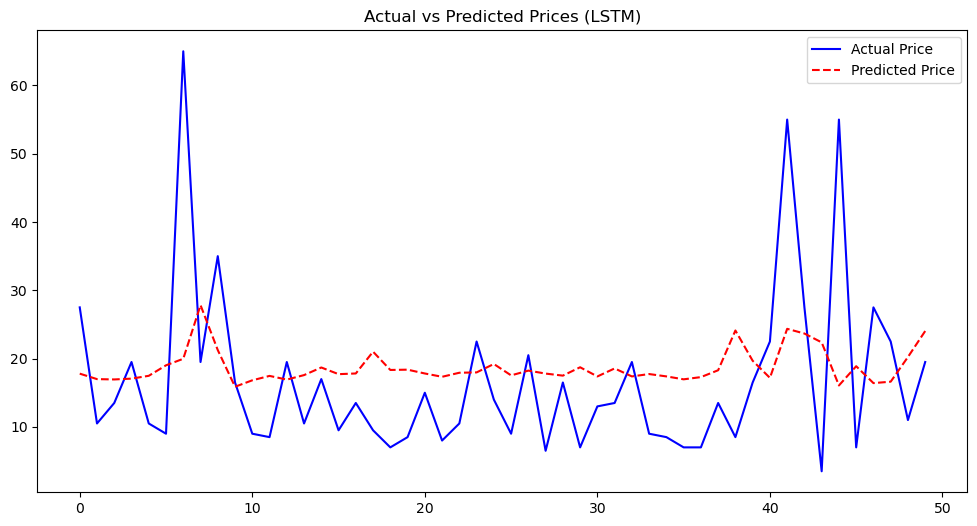

In [166]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1. عمل التوقعات
predictions = model.predict(X_test)

# 2. حساب نسبة الخطأ
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# 3. رسم بياني للمقارنة (أول 50 عينة فقط للوضوح)
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50], label='Actual Price', color='blue')
plt.plot(predictions[:50], label='Predicted Price', color='red', linestyle='--')
plt.title('Actual vs Predicted Prices (LSTM)')
plt.legend()
plt.show()

In [117]:
data_len= len(df)
print(data_len)

100000


In [118]:
train_size = int(data_len * 0.8)
print(train_size)

80000


In [119]:
train_data = df[0:train_size]

In [120]:
train_data.tail()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,name,hour,date,temp,clouds,pressure,rain,humidity,wind,dt
79995,1.21,Uber,2018-12-15 17:55:10.666,North End,Financial District,12.0,1.0,UberXL,17,2018-12-15,51.63,0.71,1021.59,0.004059,0.76,6.77,2018-12-15 17:55:10.666
79996,1.64,Uber,2018-12-15 17:55:12.456,Back Bay,Northeastern University,17.0,1.0,Black,17,2018-12-15,51.91,0.73,1021.59,0.004059,0.75,6.61,2018-12-15 17:55:12.456
79997,1.54,Lyft,2018-12-15 17:55:12.539,Theatre District,North End,7.0,1.0,Shared,17,2018-12-15,51.81,0.70,1021.60,0.004059,0.75,6.81,2018-12-15 17:55:12.539
79998,2.59,Lyft,2018-12-15 17:55:12.673,North End,Back Bay,26.0,1.0,Lux Black,17,2018-12-15,51.88,0.72,1021.59,0.004059,0.75,6.68,2018-12-15 17:55:12.673
79999,1.57,Uber,2018-12-15 17:55:12.728,North End,Theatre District,12.0,1.0,UberXL,17,2018-12-15,51.81,0.71,1021.59,0.004059,0.75,6.73,2018-12-15 17:55:12.728


In [121]:
test_data = df[train_size:data_len]

In [122]:
test_data.tail()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,name,hour,date,temp,clouds,pressure,rain,humidity,wind,dt
99995,2.56,Uber,2018-12-18 18:55:11.637,Northeastern University,Beacon Hill,33.0,1.0,Black SUV,18,2018-12-18,30.80,0.0,1012.32,0.003144,0.46,13.08,2018-12-18 18:55:11.637
99996,3.06,Lyft,2018-12-18 18:55:11.920,Fenway,Theatre District,27.5,1.0,Lux Black,18,2018-12-18,30.81,0.0,1012.32,0.003144,0.46,13.15,2018-12-18 18:55:11.920
99997,2.27,Uber,2018-12-18 18:55:11.962,Boston University,Beacon Hill,8.5,1.0,UberX,18,2018-12-18,30.80,0.0,1012.32,0.003144,0.46,13.08,2018-12-18 18:55:11.962
99998,1.23,Lyft,2018-12-18 18:55:13.279,West End,North End,3.0,1.0,Shared,18,2018-12-18,30.85,0.0,1012.31,0.003144,0.46,13.14,2018-12-18 18:55:13.279
99999,1.23,Lyft,2018-12-18 18:55:13.279,West End,North End,13.5,1.0,Lyft XL,18,2018-12-18,30.85,0.0,1012.31,0.003144,0.46,13.14,2018-12-18 18:55:13.279


In [123]:
print('Train Size',len(train_data) )
print('Test Size',len(test_data) )

Train Size 80000
Test Size 20000


In [124]:
trian_array= train_data.loc[:,['price']].values
test_array =test_data.loc[:,['price']].values

In [125]:
trian_array

array([[10.5],
       [62.5],
       [47.5],
       ...,
       [ 7. ],
       [26. ],
       [12. ]])

In [126]:
scaler = MinMaxScaler()

In [127]:
train_scaled = scaler.fit_transform(trian_array)

In [128]:
train_scaled

array([[0.08421053],
       [0.63157895],
       [0.47368421],
       ...,
       [0.04736842],
       [0.24736842],
       [0.1       ]])

In [129]:
train_scaled[40:80]

array([[0.07368421],
       [0.31578947],
       [0.08421053],
       [0.63157895],
       [0.47368421],
       [0.21052632],
       [0.28947368],
       [0.33157895],
       [0.13157895],
       [0.05263158],
       [0.25789474],
       [0.06315789],
       [0.25789474],
       [0.06842105],
       [0.08421053],
       [0.43157895],
       [0.17894737],
       [0.11578947],
       [0.21052632],
       [0.05263158],
       [0.24736842],
       [0.00526316],
       [0.25263158],
       [0.10526316],
       [0.31578947],
       [0.21052632],
       [0.45263158],
       [0.11578947],
       [0.26315789],
       [0.14736842],
       [0.06315789],
       [0.27368421],
       [0.28947368],
       [0.14736842],
       [0.04736842],
       [0.04736842],
       [0.17894737],
       [0.21052632],
       [0.06842105],
       [0.14736842]])

In [130]:
train_scaled.shape

(80000, 1)

In [131]:
# Time Serise Modeling [Time Window]
time_step = 40 


x_train = [] 
y_train = []

for i in range(time_step,len(train_scaled)):
    x_train.append(train_scaled[i-time_step:i,0])
    y_train.append(train_scaled[i,0])

In [132]:
x_train[5].shape

(40,)

In [133]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [134]:
print('x_train shape',x_train.shape )
print('y_train shape',y_train.shape )

x_train shape (79960, 40)
y_train shape (79960,)


In [135]:
x_train.shape[0] , x_train.shape[1],1

(79960, 40, 1)

In [136]:
x_train = np.reshape(x_train,(x_train.shape[0] , x_train.shape[1],1))

In [137]:
print('x_train shape',x_train.shape )
print('y_train shape',y_train.shape )

x_train shape (79960, 40, 1)
y_train shape (79960,)


In [138]:
y_train


array([0.07368421, 0.31578947, 0.08421053, ..., 0.04736842, 0.24736842,
       0.1       ])

In [139]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(50,activation='tanh',return_sequences = True ,input_shape=(x_train.shape[1],1)))

rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(50,activation='tanh',return_sequences = True))

rnn_model.add(Dropout(0.2))

rnn_model.add(SimpleRNN(50))

rnn_model.add(Dense(1))


In [140]:
rnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 40, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 40, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 40, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,751 (49.81 KB)

 Trainable params: 12,751 (49.81 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
rnn_model.compile(
    optimizer = 'adam',
    loss= 'mse'
)

In [142]:
rnn_model.fit(x_train,y_train,epochs = 10)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 123s 23ms/step - loss: 0.0160
Epoch 2/10
1294/2499 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0143

KeyboardInterrupt: 

In [ ]:
total_data = pd.concat((df['price'],test_data['price']),axis=0)

In [ ]:
total_data.shape

(120000,)

In [ ]:
inputs = total_data[len(total_data)-len(test_data)-time_step:].values.reshape(-1,1)

In [ ]:
inputs.shape

(20040, 1)

In [ ]:
# Time Serise Modeling [Time Window]
x_test = [] 

for i in range(time_step,len(inputs)):
    x_test.append(inputs[i-time_step:i])

In [ ]:
x_test = np.array(x_test)
x_test.shape

(20000, 40, 1)

In [ ]:
y_rnn = rnn_model.predict(x_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(50,activation='tanh',return_sequences = True ,input_shape=(x_train.shape[1],1)))

lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(50,activation='tanh',return_sequences = True))

lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(50))

lstm_model.add(Dense(1))


In [ ]:
lstm_model.compile(
    optimizer = 'adam',
    loss= 'mse'
)

In [ ]:
lstm_y = lstm_model.predict(x_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


In [ ]:
mse = mean_squared_error(test_array,scaler.inverse_transform(lstm_y))
rmse = np.sqrt(mse)

In [ ]:
mse

210.38682159210356

In [ ]:
rmse

np.float64(14.504717218619037)